In [1]:
import numpy as np
import codecs
import json
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import eigh
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import random
import networkx as nx
import community as community_louvain
import matplotlib.cm as cm
import pandas as pd
import scprep
from sklearn.manifold import TSNE
import phate


In [2]:
def load_json_files(file_path):
    '''
    Loads data from a json file

    Inputs:
        file_path   the path of the .json file that you want to read in

    Outputs:
        my_array    this is a numpy array if data is numeric, it's a list if it's a string

    '''

    #  load data from json file
    with codecs.open(file_path, 'r', encoding='utf-8') as handle:
        json_data = json.loads(handle.read())

    # if a string, then returns list of strings
    if not isinstance(json_data[0], str):
        # otherwise, it's assumed to be numeric and returns numpy array
        json_data = np.array(json_data)

    return json_data

In [4]:
swiss_roll_points=load_json_files("swiss_roll_points.json")
swiss_roll_labels=load_json_files("swiss_roll_labels.json")
retinal_data= pd.read_pickle("retinal-bipolar-data.pickle")
retinal_metadata= pd.read_pickle("retinal-bipolar-metadata.pickle")

In [2]:
def gaussian_kernel(X, kernel_type="gaussian", sigma=3.0, k=5):
    """gaussian_kernel: Build an adjacency matrix for data using a Gaussian kernel
    Args:
        X (N x d np.ndarray): Input data
        kernel_type: "gaussian" or "adaptive". Controls bandwidth
        sigma (float): Scalar kernel bandwidth
        k (integer): nearest neighbor kernel bandwidth
    Returns:
        W (N x N np.ndarray): Weight/adjacency matrix induced from X
    """
    _g = "gaussian"
    _a = "adaptive"

    kernel_type = kernel_type.lower()
    D = squareform(pdist(X))
    if kernel_type == "gaussian":  # gaussian bandwidth checking
        print("fixed bandwidth specified")
        
        if not all([type(sigma) is float, sigma > 0]):  # [float, positive]
            print("invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth")
            D_find = D + np.eye(np.size(D, 1)) * 1e15
            sigma = np.max(np.min(D_find, 1))
            del D_find
        sigma = np.ones(np.size(D, 1)) * sigma
    elif kernel_type == "adaptive":  # adaptive bandwidth
        print("adaptive bandwidth specified")

        # [integer, positive, less than the total samples]
        if not all([type(k) is int, k > 0, k < np.size(D, 1)]):
            print("invalid adaptive bandwidth, using k=5 as bandwidth")
            k = 5

        knnDST = np.sort(D, axis=1)  # sorted neighbor distances
        sigma = knnDST[:, k]  # k-nn neighbor. 0 is self.
        del knnDST
    else:
        raise ValueError
    W = ((D**2) / sigma[:, np.newaxis]**2).T
    W = np.exp(-1 * (W))
    W = (W + W.T) / 2  # symmetrize
    W = W - np.eye(W.shape[0])  # remove the diagonal
    return W


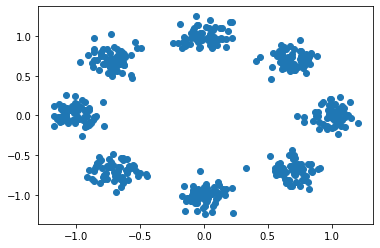

In [184]:
def sbm(N, k, pij, pii, sigma):
    """sbm: Construct a stochastic block model
        
    Args:
        N (integer): Graph size
        k (integer): Number of clusters
        pij (float): Probability of intercluster edges
        pii (float): probability of intracluster edges

    Returns:
        A (numpy.array): Adjacency Matrix
        gt (numpy.array): Ground truth cluster labels
        coords(numpy.array): plotting coordinates for the sbm
    """
    gt= np.empty(N)
    for j in range(0,N):
        gt[j] = j % k
    gt = np.sort(gt)
    A = np.empty((N,N))
    for a in range(0,N):
        for g in range(a,N):
            rand=np.random.uniform()

            if ((gt[a]==gt[g]) & (rand <= pii)):
                A[a,g]=1
                A[g,a]=1
            if((gt[a]!=gt[g]) & (rand <= pij)):
                A[a,g]=1
                A[g,a]=1
            if ((gt[a]==gt[g]) & (rand > pii)):
                A[a,g]=0
                A[g,a]=0
            if((gt[a]!=gt[g]) & (rand > pij)):
                A[a,g]=0
                A[g,a]=0
            if(a==g):
                A[a,g]=0
    coords = np.empty((N,2))
    centers= np.empty((k,2))
    
    for i in range(0,k):
        angle = 2 * math.pi *(i/k)
        coord=np.empty(2)
        coord[0]= math.cos(angle)
        coord[1]= math.sin(angle)
        centers[i,:]= coord
        
    
    for l in range(0,len(gt)):

        coords[l,0]= centers[int(gt[l]),0]+np.random.normal(0, math.sqrt(sigma))
        coords[l,1]= centers[int(gt[l]),1]+np.random.normal(0,math.sqrt(sigma))

    return A, gt, coords

A3, gt3, coordinates = sbm(500, 8, 0, .65, 0.01)
plt.scatter(coordinates[:,0], coordinates[:,1])


In [186]:
def L(A, normalized=True):
    """L: compute a graph laplacian

    Args:
        A (N x N np.ndarray): Adjacency matrix of graph
        normalized (bool, optional): Normalized or combinatorial Laplacian

    Returns:
        L (N x N np.ndarray): graph Laplacian
    """
    D = np.diag(A.sum(axis=1))
    Dhalf = np.diag((A.sum(axis=1))**(-0.5))
    if normalized==False:
        L = D-A
    else: 
        L = Dhalf @ (D-A) @ Dhalf
    return L
    




In [115]:
def compute_fourier_basis(L):
    """compute_fourier_basis: Laplacian Diagonalization

    Args:
        L (N x N np.ndarray): graph Laplacian

    Returns:
        e (N x 1 np.ndarray): graph Laplacian eigenvalues
        psi (N x N np.ndarray): graph Laplacian eigenvectors
    """
    eig,vec = eigh(L)
    indices=np.argsort(eig)
    eig=eig[indices]
    psi=vec[indices,:]
    return eig, psi


In [116]:
def gft(s, psi):
    """gft: Graph Fourier Transform (GFT)

    Args:
        s (N x d np.ndarray): Matrix of graph signals.  Each column is a signal.
        psi (N x N np.ndarray): graph Laplacian eigenvectors
    Returns:
        s_hat (N x d np.ndarray): GFT of the data
    """
    s_hat = psi.T @ s
    return s_hat


In [117]:
def filterbank_matrix(psi, e, h):
    """filterbank_matrix: build a filter matrix using the input filter h

    Args:
        psi (N x N np.ndarray): graph Laplacian eigenvectors
        e (N x 1 np.ndarray): graph Laplacian eigenvalues
        h (function handle): A function that takes in eigenvalues
        and returns values in the interval (0,1)

    Returns:
        H (N x N np.ndarray): Filter matrix that can be used in the form
        filtered_s = H@s
    """
    h_evals = np.zeros(len(psi))
    for i in range(0,len(e)):
        h_evals[i] = h(e[i])
    H = psi @ np.diag(h_evals) @ psi.T
    return H


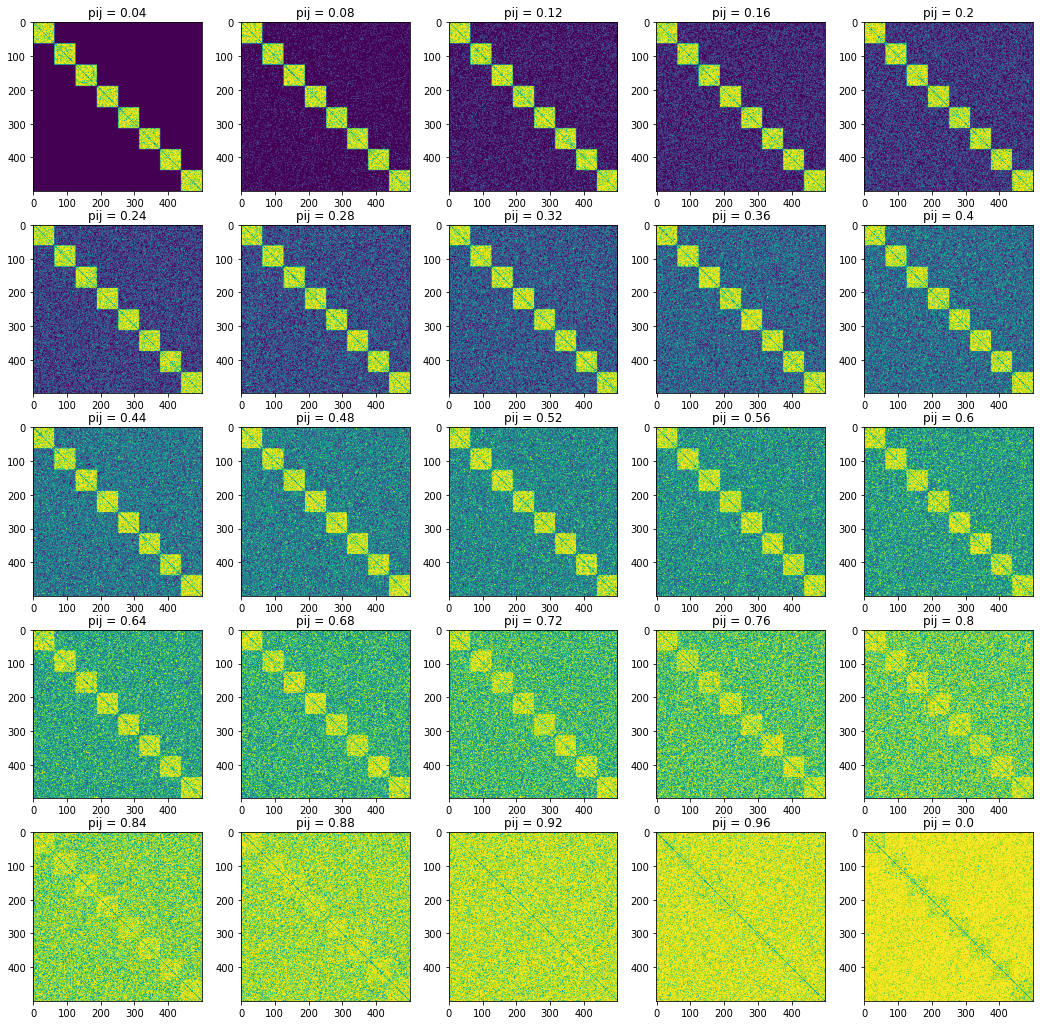

In [177]:
array=np.arange(0 ,1 , 0.04)
figure, axes = plt.subplots(nrows=5, ncols=5, figsize=(18,18))
for i in range(0,len(array)):
    A2, gt2, coords2= sbm(500, 8, array[i], 0.9, 0.02)
    plt.title('pij = '+ str(array[i]))
    plt.subplot(5,5, i+1,)
    plt.imshow(A2)

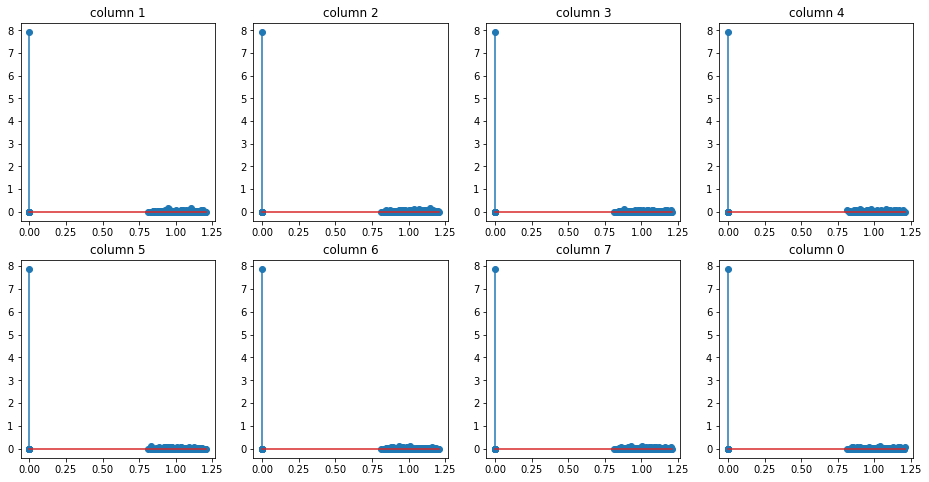

In [119]:
A3, gt3, coordinates = sbm(500, 8, 0, 0.65, 0.01)
num_clust=8
one_hot= np.empty((500,num_clust))

figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))


for r in range(0,len(gt3)):
    for m in range(0,num_clust):
        if gt3[r]==m:
            one_hot[r,m] = 1
        else: 
            one_hot[r,m] = 0

laplace = L(A3)
e2, psi2= compute_fourier_basis(laplace)
gft1 = gft(one_hot, psi2)
for j in range(0,8):
    plt.title('column '+ str(j))
    plt.subplot(2,4, j+1,)
    plt.stem(e2, abs(gft1[:,j]))



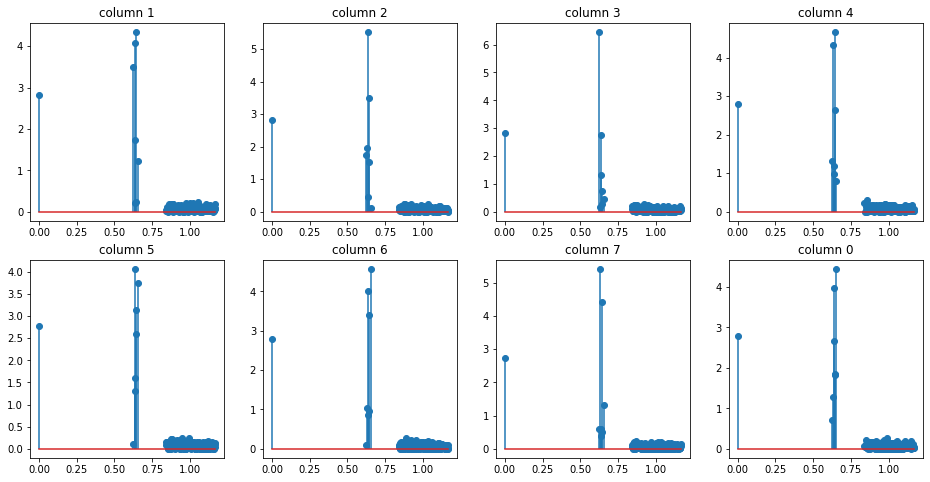

In [240]:
A3, gt3, coordinates = sbm(500, 8, 0.125, 0.65, 0.01)
num_clust=8
one_hot= np.empty((500,num_clust))

figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))


for r in range(0,len(gt3)):
    for m in range(0,num_clust):
        if gt3[r]==m:
            one_hot[r,m] = 1
        else: 
            one_hot[r,m] = 0

laplace = L(A3)
e2, psi2= compute_fourier_basis(laplace)
gft1 = gft(one_hot, psi2)
for j in range(0,8):
    plt.title('column '+ str(j))
    plt.subplot(2,4, j+1,)
    plt.stem(e2, abs(gft1[:,j]))

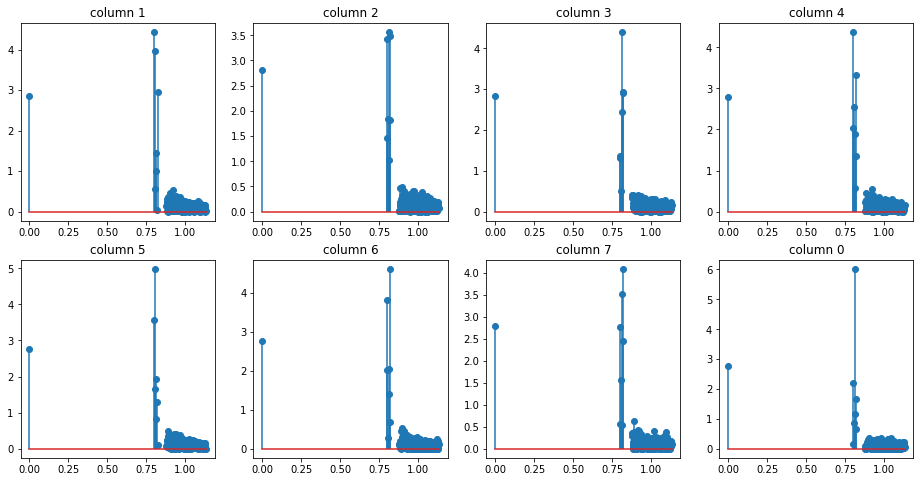

In [241]:
A3, gt3, coordinates = sbm(500, 8, 0.25, .65, 0.01)
num_clust=8
one_hot= np.empty((500,num_clust))

figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))


for r in range(0,len(gt3)):
    for m in range(0,num_clust):
        if gt3[r]==m:
            one_hot[r,m] = 1
        else: 
            one_hot[r,m] = 0

laplace = L(A3)
e2, psi2= compute_fourier_basis(laplace)
gft1 = gft(one_hot, psi2)
for j in range(0,8):
    plt.title('column '+ str(j))
    plt.subplot(2,4, j+1,)
    plt.stem(e2, abs(gft1[:,j]))

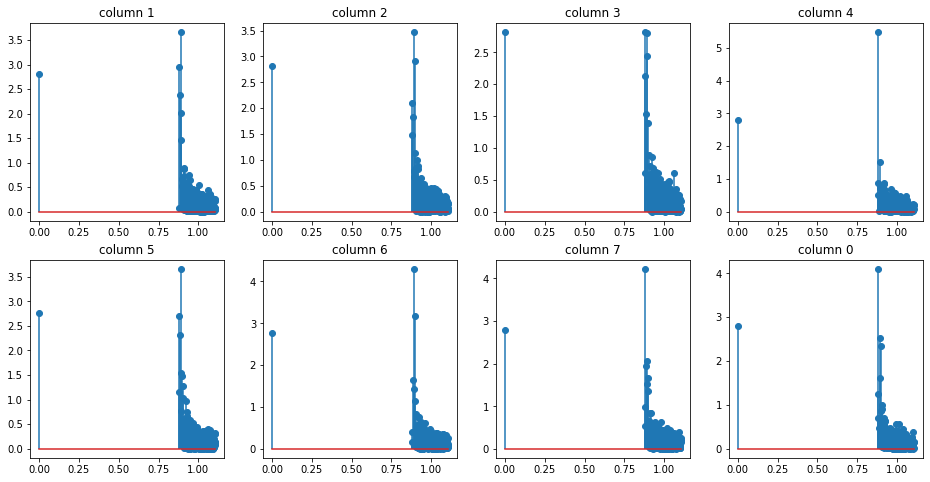

In [242]:
A3, gt3, coordinates = sbm(500, 8, 0.375, .65, 0.01)
num_clust=8
one_hot= np.empty((500,num_clust))

figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))


for r in range(0,len(gt3)):
    for m in range(0,num_clust):
        if gt3[r]==m:
            one_hot[r,m] = 1
        else: 
            one_hot[r,m] = 0

laplace = L(A3)
e2, psi2= compute_fourier_basis(laplace)
gft1 = gft(one_hot, psi2)
for j in range(0,8):
    plt.title('column '+ str(j))
    plt.subplot(2,4, j+1,)
    plt.stem(e2, abs(gft1[:,j]))

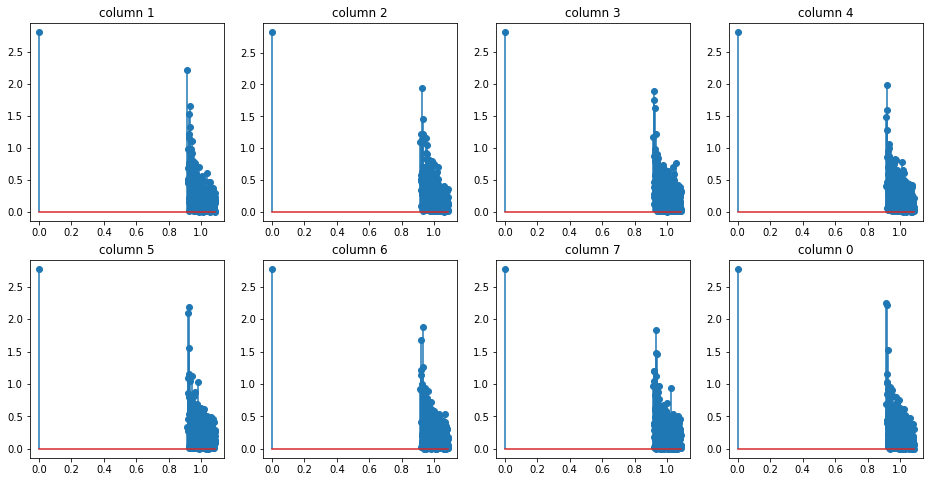

In [243]:
A3, gt3, coordinates = sbm(500, 8, 0.5, .65, 0.01)
num_clust=8
one_hot= np.empty((500,num_clust))

figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))


for r in range(0,len(gt3)):
    for m in range(0,num_clust):
        if gt3[r]==m:
            one_hot[r,m] = 1
        else: 
            one_hot[r,m] = 0

laplace = L(A3)
e2, psi2= compute_fourier_basis(laplace)
gft1 = gft(one_hot, psi2)
for j in range(0,8):
    plt.title('column '+ str(j))
    plt.subplot(2,4, j+1,)
    plt.stem(e2, abs(gft1[:,j]))

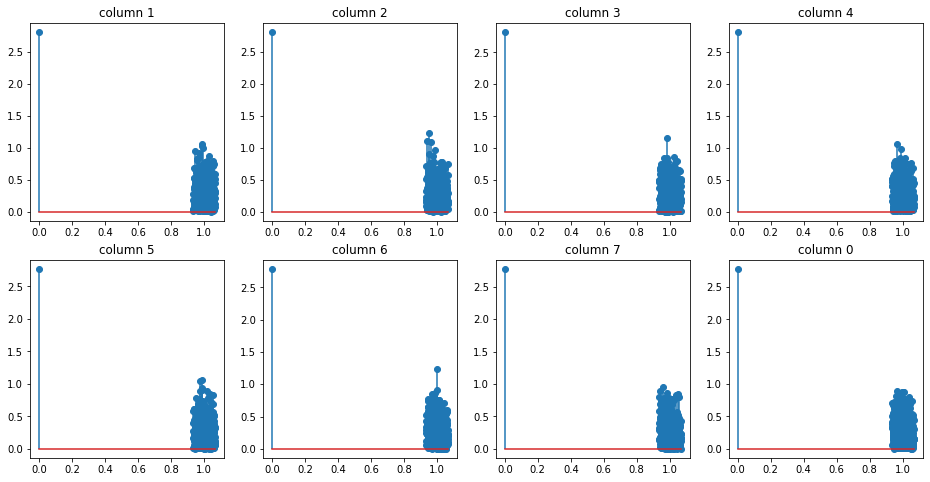

In [244]:
A3, gt3, coordinates = sbm(500, 8, 0.625, .65, 0.01)
num_clust=8
one_hot= np.empty((500,num_clust))

figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))


for r in range(0,len(gt3)):
    for m in range(0,num_clust):
        if gt3[r]==m:
            one_hot[r,m] = 1
        else: 
            one_hot[r,m] = 0

laplace = L(A3)
e2, psi2= compute_fourier_basis(laplace)
gft1 = gft(one_hot, psi2)
for j in range(0,8):
    plt.title('column '+ str(j))
    plt.subplot(2,4, j+1,)
    plt.stem(e2, abs(gft1[:,j]))

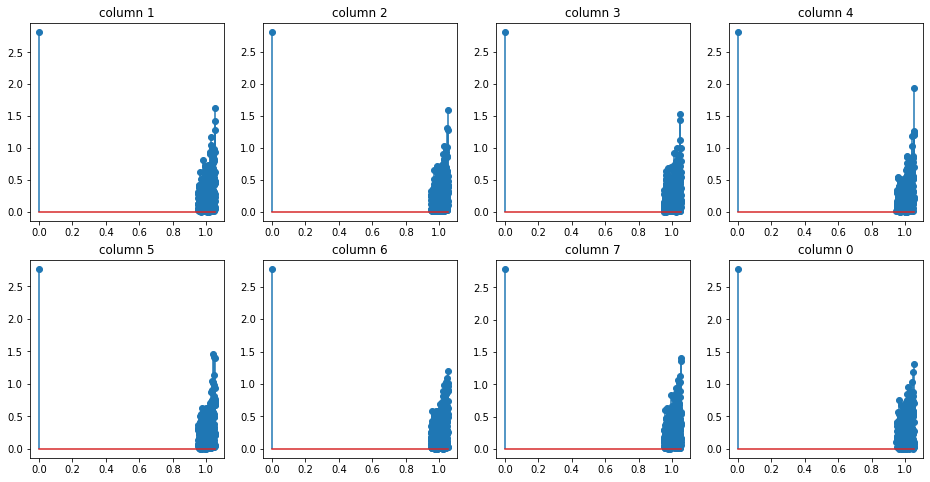

In [245]:
A3, gt3, coordinates = sbm(500, 8, 0.75, .65, 0.01)
num_clust=8
one_hot= np.empty((500,num_clust))

figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))


for r in range(0,len(gt3)):
    for m in range(0,num_clust):
        if gt3[r]==m:
            one_hot[r,m] = 1
        else: 
            one_hot[r,m] = 0

laplace = L(A3)
e2, psi2= compute_fourier_basis(laplace)
gft1 = gft(one_hot, psi2)
for j in range(0,8):
    plt.title('column '+ str(j))
    plt.subplot(2,4, j+1,)
    plt.stem(e2, abs(gft1[:,j]))

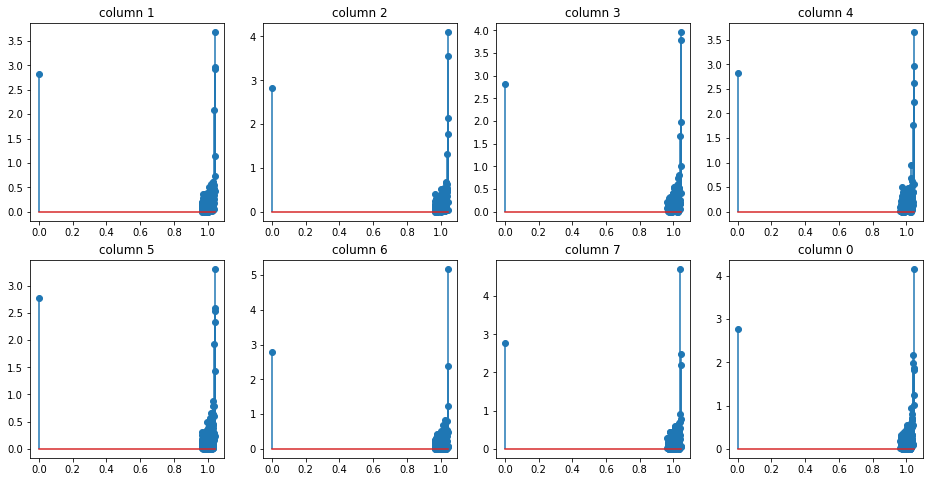

In [246]:
A3, gt3, coordinates = sbm(500, 8, 0.875, .65, 0.01)
num_clust=8
one_hot= np.empty((500,num_clust))

figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))


for r in range(0,len(gt3)):
    for m in range(0,num_clust):
        if gt3[r]==m:
            one_hot[r,m] = 1
        else: 
            one_hot[r,m] = 0

laplace = L(A3)
e2, psi2= compute_fourier_basis(laplace)
gft1 = gft(one_hot, psi2)
for j in range(0,8):
    plt.title('column '+ str(j))
    plt.subplot(2,4, j+1,)
    plt.stem(e2, abs(gft1[:,j]))

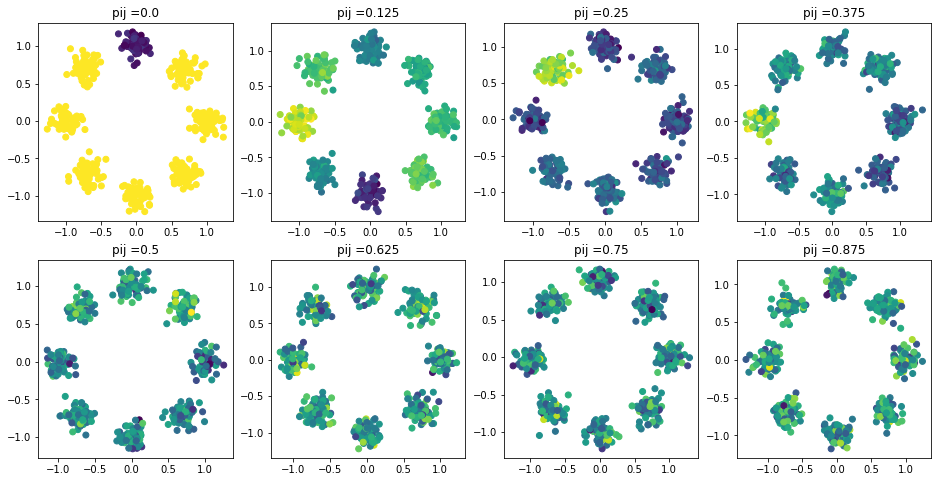

In [124]:
array= np.arange(0,1,1/8)
figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

for d in range(0,len(array)): 
    A4, gt3, coordinates = sbm(500, 8, array[d], 0.65, 0.01)
    laplace = L(A4)
    e4, psi4= compute_fourier_basis(laplace)
    plt.subplot(2,4, d+1)
    
    plt.title("pij =" + str(array[d]))
    plt.scatter(coordinates[:,0], coordinates[:,1], c=psi4[:,2])

In [333]:
noise = np.random.normal(0, 1, 500)
threshold=0.1
A10, gt10, coordinates10 = sbm(500, 8, 0.01, .9, 0.01)
laplace = L(A10)
evals, evecs = compute_fourier_basis(laplace)
    

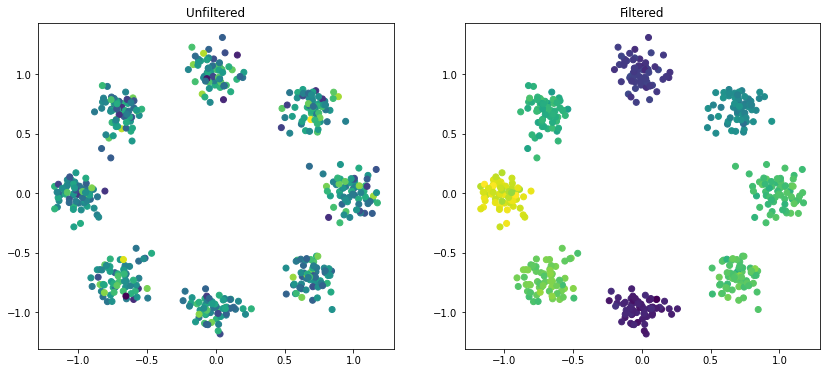

In [334]:
filtered= filterbank_matrix(evecs, evals, lambda x: int(x<threshold))

unfiltered_labels = abs(evecs.T @ noise)
filtered_labels = abs(filtered @ noise)

figure , axes = plt.subplots(nrows = 1, ncols = 2, figsize= (14, 6))

plt.subplot(1,2, 1)
plt.title("Unfiltered")
plt.scatter(coordinates10[:,0], coordinates10[:,1], c = noise)

plt.subplot(1, 2, 2)
plt.title("Filtered")
plt.scatter(coordinates10[:,0], coordinates10[:,1], c = filtered_labels)

<StemContainer object of 3 artists>

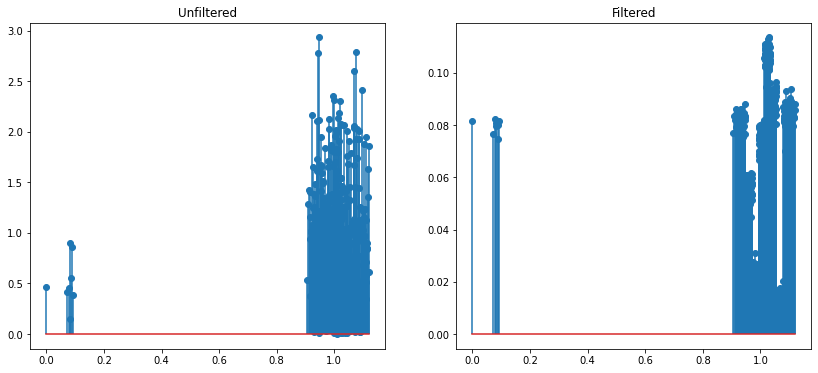

In [335]:
figure , axes = plt.subplots(nrows = 1, ncols = 2, figsize= (14, 6))

plt.subplot(1,2,1)
plt.title('Unfiltered')
plt.stem(evals, unfiltered_labels)

plt.subplot(1,2,2)
plt.title('Filtered')
plt.stem(evals, filtered_labels)


In [321]:
def centering(data):
    mean_center=np.empty(data.shape)
    for i in range(0,len(data[0])):
        mean_center[:,i]=(data[:,i]-np.mean(data[:,i], axis=0))
    return mean_center

mean_center_labels=swiss_roll_labels-np.mean(swiss_roll_labels, axis=0)
mean_center_swiss_points=centering(swiss_roll_points)

def compute_distances(X):
    
    #matrix of Euclidean distances
    distance_matrix=np.empty((len(X), len(X)))
    for i in range(0,len(X)):
        for j in range(0, len(X)):
            distance_matrix[i][j] = np.sqrt((X[i,:]-X[j,:]) @ (X[i,:]-X[j,:])) 
    
               
    return distance_matrix

def diff_map_info(W):
    #takes in kernel matrix
    D_half=np.diag((np.sum(W, axis=1)**(-0.5)))
    
    #construct symmetric matrix 
    M= D_half @ W @ D_half 
    
    #compute eigenvector and values
    diff_eig, diff_vec= np.linalg.eigh(M)
    
    #sort eigenvalues and eigenvectors
    inds = (np.argsort(diff_eig))
    inds=inds[::-1]
    diff_eig = diff_eig[inds][0:W.shape[0]]
    diff_vec = diff_vec[:, inds]
    diff_vec_norm=np.empty(diff_vec.shape)
    eigvectors = D_half @ diff_vec
    
    #normalize eigenvectors 
    eigvectors = (eigvectors) / np.linalg.norm(eigvectors, axis = 0)
    diff_vec = eigvectors[:, 0:W.shape[0]]
    
    return diff_vec, diff_eig


def get_diff_map(diff_vec, diff_eig, t):
    #remove first eigenvector and eigenvalue
    diff_eig=np.delete(diff_eig,0)
    
    diff_vec=diff_vec[:, 1:len(diff_vec[0])]
    
    #construct diffusion map
    diff_map=np.empty(diff_vec.shape)
    
    for i in range(0, len(diff_eig)):
        diff_map[:,i]=diff_eig[i]**t*diff_vec[:,i]

    return diff_map

def compute_affinity_matrix(D, kerneltype, sigma=None, k=None):
    #computes using static type kernel with fixed sigma 
    W=np.empty((len(D), len(D)))
    if (kerneltype=="static"):
        
        for i in range(0,len(D)):
            for j in range(0, len(D)):
                W[i][j]=np.exp(((-(D[i,j])**2))/sigma**2)
    
    #uses helper functions to implement Gaussian k-nearest neighbor kernel 
    if (kerneltype=="adaptive"):
        sorted_distance_matrix=np.empty((len(D), len(D)))
        for i in range(0,len(D)):
            sorted_distance_matrix[i,:]=np.sort(D[i,:][::-1])
        for i in range(0,len(D)):
            for j in range(0, len(D)):
                denominator=(-1*(D[i,j])**2)
                W[i][j]=0.5*(np.exp(denominator/(sorted_distance_matrix[i,k])\
                **2)+np.exp(denominator/(sorted_distance_matrix[j,k])**2))
    # return the affinity matrix
    return W

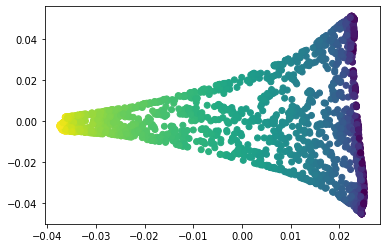

In [129]:
distances=compute_distances(mean_center_swiss_points)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=5)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,1)

plt.scatter(diff_map[:,0], diff_map[:,1], c = mean_center_labels)
   

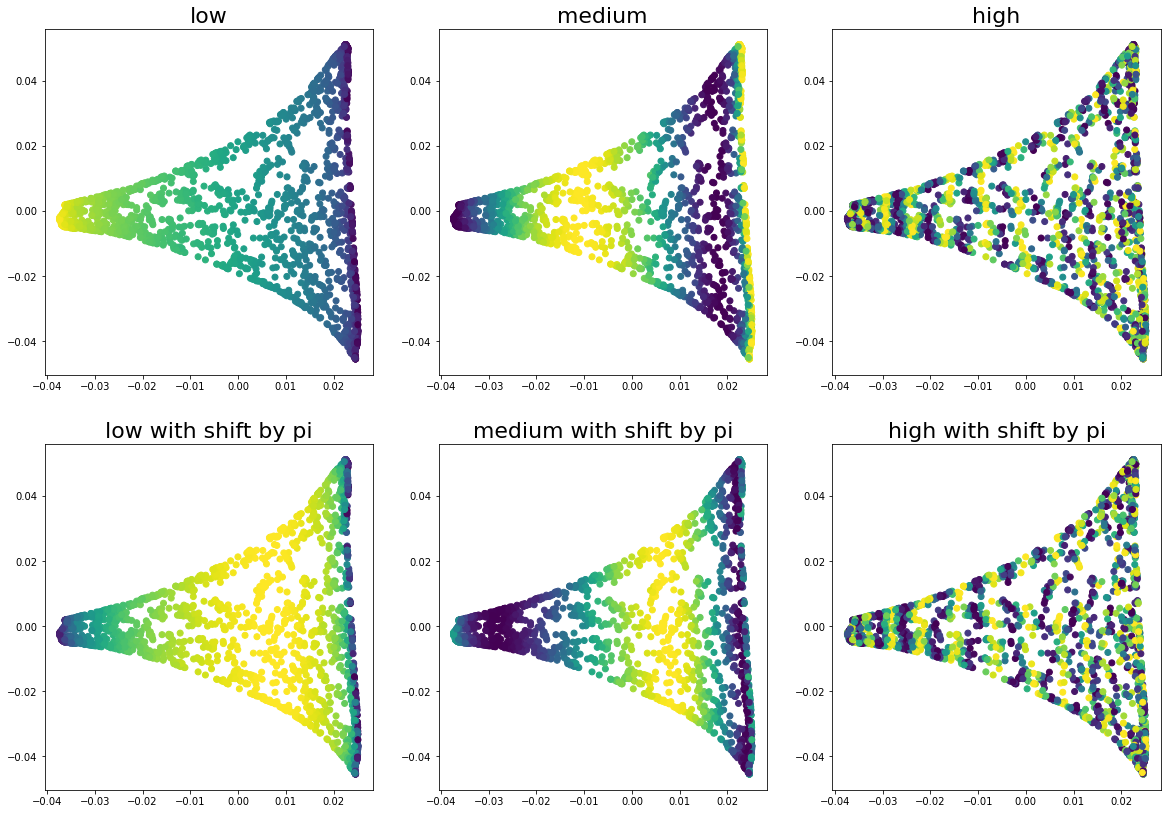

In [130]:
low = np.sin(mean_center_labels)
med = np.sin(10*mean_center_labels)
high = np.sin(100*mean_center_labels)

lowshift = np.sin(mean_center_labels + math.pi/2)
medshift = np.sin(10*mean_center_labels + math.pi/2)
highshift = np.sin(100*mean_center_labels + math.pi/2)

figure , axes = plt.subplots(nrows = 2, ncols = 3, figsize= (20, 14))

plt.subplot(2,3,1)
plt.title('low', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = low)


plt.subplot(2,3,2)
plt.title('medium', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = med)


plt.subplot(2,3,3)
plt.title('high', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = high)

plt.subplot(2,3,4)
plt.title('low with shift by pi', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = lowshift)


plt.subplot(2,3,5)
plt.title('medium with shift by pi', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = medshift)


plt.subplot(2,3,6)
plt.title('high with shift by pi', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = highshift)



<StemContainer object of 3 artists>

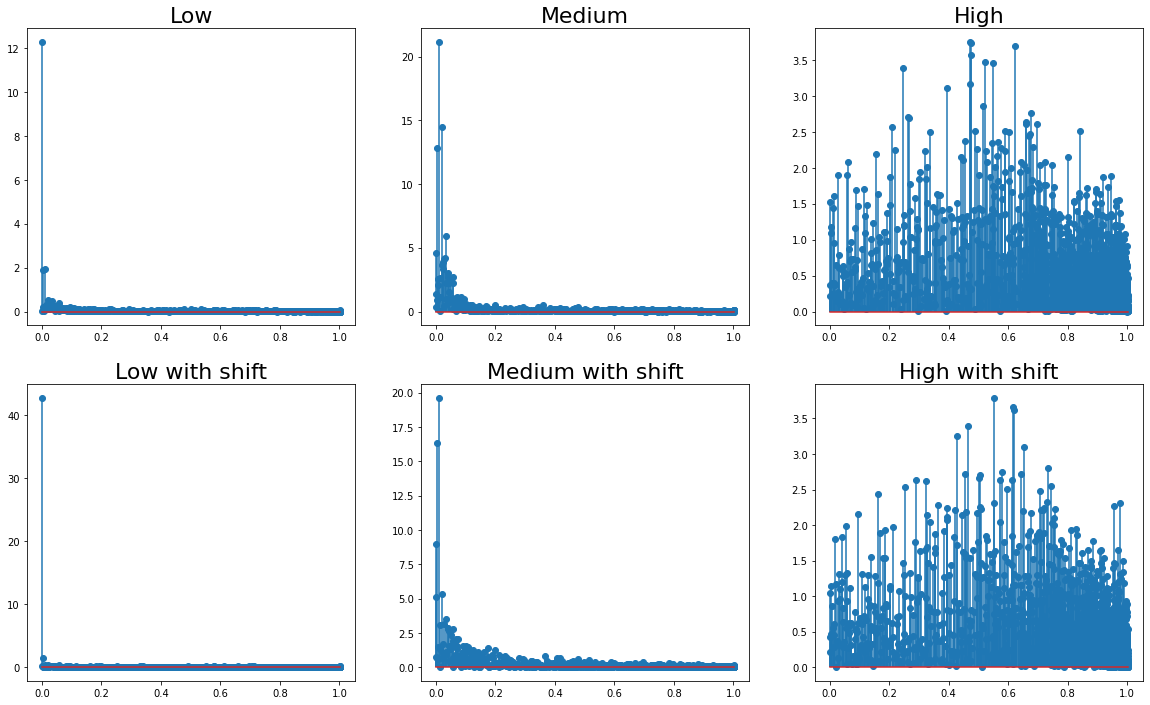

In [131]:
Laplace = L(aff_matrix)
evals2, evecs2 = compute_fourier_basis(Laplace)
low_signal = abs(gft(low, evecs2))
med_signal = abs(gft(med, evecs2))
high_signal = abs(gft(high, evecs2))
low_signalshift = abs(gft(lowshift, evecs2))
med_signalshift = abs(gft(medshift, evecs2))
high_signalshift = abs(gft(highshift, evecs2))

figure , axes = plt.subplots(nrows = 2, ncols = 3, figsize= (20,12 ))

plt.subplot(2,3,1)
plt.title('Low', fontsize=22)
plt.stem(evals2, low_signal)

plt.subplot(2,3,2)
plt.title('Medium', fontsize=22)
plt.stem(evals2, med_signal)

plt.subplot(2,3,3)
plt.title('High', fontsize=22)
plt.stem(evals2, high_signal)

plt.subplot(2,3,4)
plt.title('Low with shift', fontsize=22)
plt.stem(evals2, low_signalshift)

plt.subplot(2,3,5)
plt.title('Medium with shift', fontsize=22)
plt.stem(evals2, med_signalshift)

plt.subplot(2,3,6)
plt.title('High with shift', fontsize=22)
plt.stem(evals2, high_signalshift)

<StemContainer object of 3 artists>

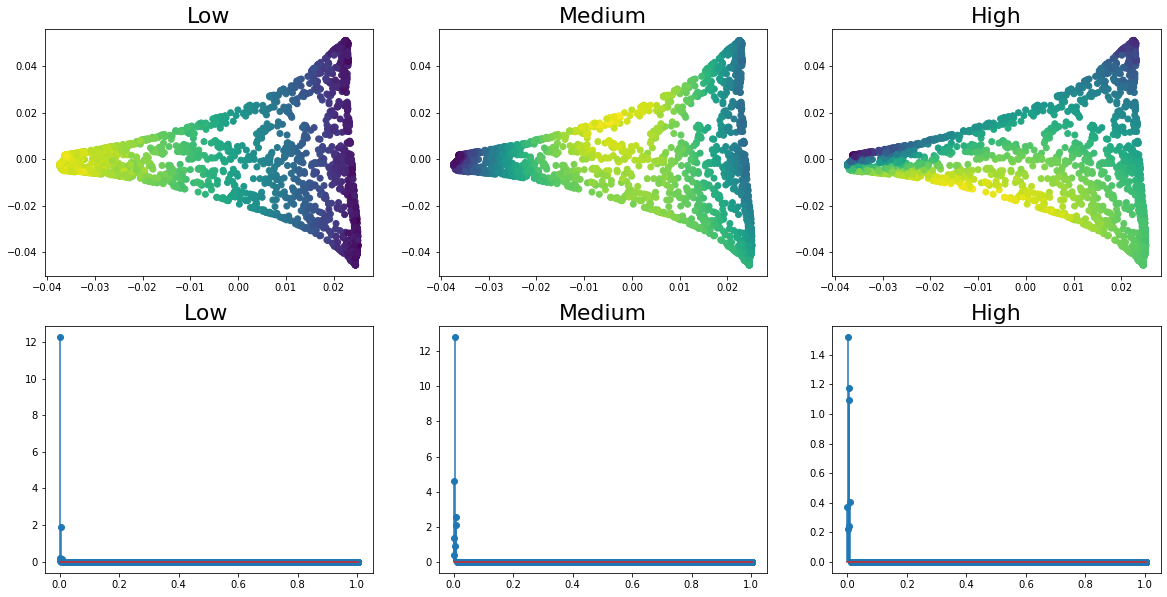

In [352]:
threshold1 = 0.01
threshold2 = 0.8

filtered1= filterbank_matrix(evecs2, evals2, lambda x: int(x<threshold1))
filtered2= filterbank_matrix(evecs2, evals2, lambda x: int(x>threshold2))

figure , axes = plt.subplots(nrows = 2, ncols = 3, figsize= (20, 10))

plt.subplot(2,3,1)
plt.title('Low', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = filtered1@low)


plt.subplot(2,3,2)
plt.title('Medium', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c =filtered1@ med)


plt.subplot(2,3,3)
plt.title('High', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = filtered1@ high)

plt.subplot(2,3,4)
plt.title('Low ', fontsize=22)
plt.stem(evals2, abs(gft(filtered1@low, evecs2)))

plt.subplot(2,3,5)
plt.title('Medium', fontsize=22)
plt.stem(evals2, abs(gft(filtered1@ med, evecs2)))

plt.subplot(2,3,6)
plt.title('High', fontsize=22)
plt.stem(evals2, abs(gft(filtered1@ high, evecs2)))


<StemContainer object of 3 artists>

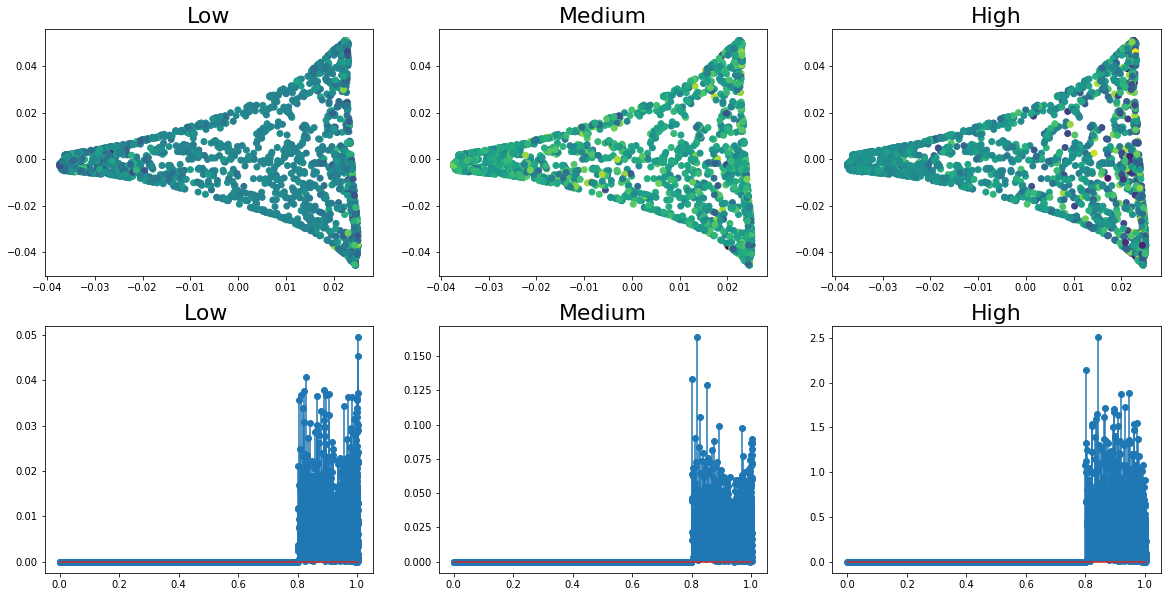

In [351]:
figure , axes = plt.subplots(nrows = 2, ncols = 3, figsize= (20, 10))

plt.subplot(2,3,1)
plt.title('Low', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = filtered2@low)


plt.subplot(2,3,2)
plt.title('Medium', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c =filtered2@ med)


plt.subplot(2,3,3)
plt.title('High', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = filtered2@ high)

plt.subplot(2,3,4)
plt.title('Low ', fontsize=22)
plt.stem(evals2, abs(gft(filtered2@low, evecs2)))

plt.subplot(2,3,5)
plt.title('Medium', fontsize=22)
plt.stem(evals2, abs(gft(filtered2@ med, evecs2)))

plt.subplot(2,3,6)
plt.title('High', fontsize=22)
plt.stem(evals2, abs(gft(filtered2@ high, evecs2)))



In [371]:

kron_one = kron_delta(int(swiss_roll_labels.shape[0]/4), swiss_roll_labels.shape[0])
kron_two = kron_delta(int(swiss_roll_labels.shape[0]/2), swiss_roll_labels.shape[0])
kron_three = kron_delta(int(3*swiss_roll_labels.shape[0]/4), swiss_roll_labels.shape[0])

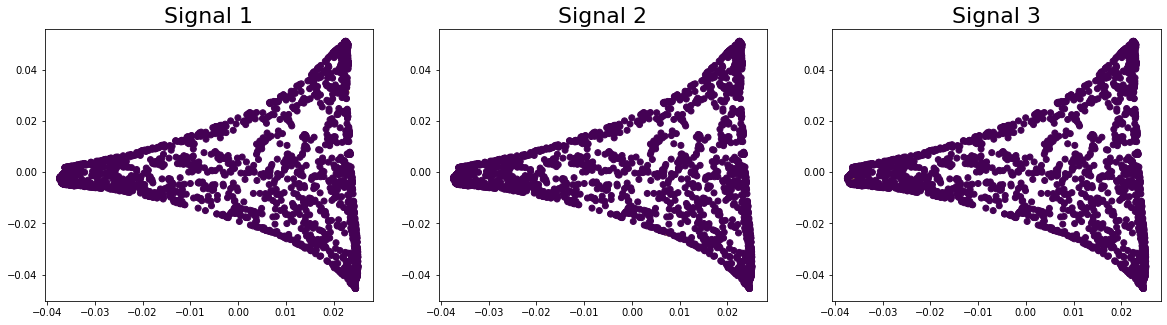

In [372]:
figure , axes = plt.subplots(nrows = 1, ncols = 3, figsize= (20, 5))

plt.subplot(1,3,1)
plt.title('Signal 1', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = kron_one)


plt.subplot(1,3,2)
plt.title('Signal 2', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = kron_two)


plt.subplot(1,3,3)
plt.title('Signal 3', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = kron_three)

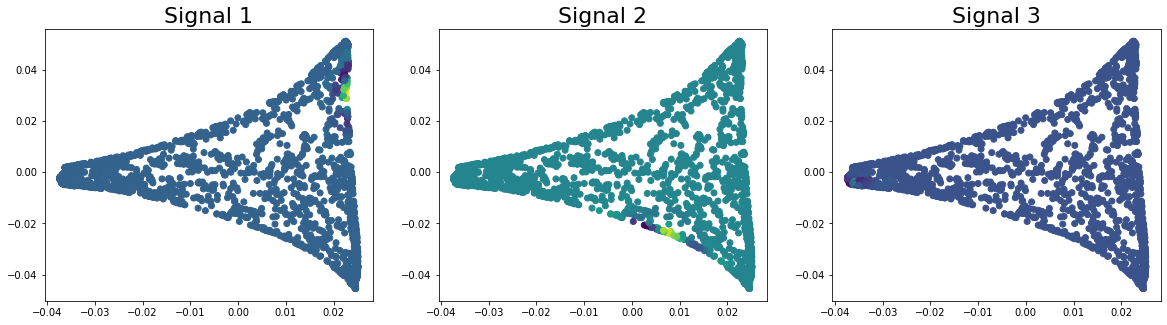

In [373]:
kronofilter = filterbank_matrix(vecs, eigs, lambda x: np.exp((-(x-0.8)**2)/(2*(0.1**2))))
filtered_label_one= kronofilter@ kron_one
filtered_label_two= kronofilter@ kron_two
filtered_label_three= kronofilter@ kron_three

figure , axes = plt.subplots(nrows = 1, ncols = 3, figsize= (20, 5))

plt.subplot(1,3,1)
plt.title('Signal 1', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = filtered_label_one)


plt.subplot(1,3,2)
plt.title('Signal 2', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = filtered_label_two)


plt.subplot(1,3,3)
plt.title('Signal 3', fontsize=22)
plt.scatter(diff_map[:,0], diff_map[:,1], c = filtered_label_three)

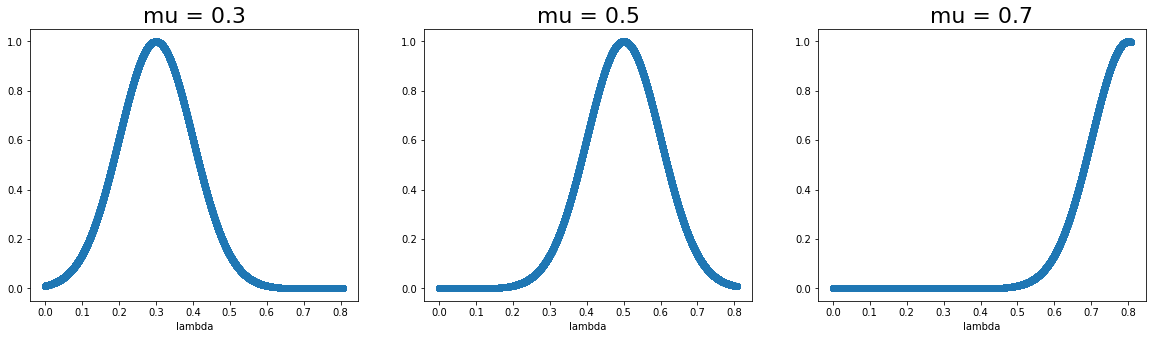

In [375]:
x_lambda= np.linspace(0,np.max(vecs), 10000)
mu3=np.exp((-(x_lambda-0.3)**2)/(2*(0.1**2)))
mu5=np.exp((-(x_lambda-0.5)**2)/(2*(0.1**2)))
mu7=np.exp((-(x_lambda-0.8)**2)/(2*(0.1**2)))

figure , axes = plt.subplots(nrows = 1, ncols = 3, figsize= (20, 5))

plt.subplot(1,3,1)
plt.title('mu = 0.3', fontsize=22)
plt.xlabel("lambda")
plt.scatter(x_lambda, mu3)


plt.subplot(1,3,2)
plt.title('mu = 0.5', fontsize=22)
plt.xlabel("lambda")

plt.scatter(x_lambda, mu5)


plt.subplot(1,3,3)
plt.title('mu = 0.7', fontsize=22)
plt.xlabel("lambda")
plt.scatter(x_lambda, mu7)


In [187]:
def calculate_distance(point1, point2):
    tsum = 0
    for i in range(0,len(point1)):
        tsum= tsum + (point1[i] - point2[i])**2
    return np.sqrt(tsum)




In [188]:
def calculate_distances(centroids, points):
    distances=[]
    for i in range(0, len(points)):
        current_distances=[]
        for h in range(0, len(centroids)):
            current_distances.append(calculate_distance(points[i], centroids[h]))
        distances.append(max(current_distances))
    return distances

In [189]:
def probability_counter(distances):
    sum_distances=sum(distances)
    probabilities=[]
    for i in range(0,len(distances)):
        probabilities.append(distances[i]/sum_distances)
    return probabilities

In [190]:
def select_new_centroid(probabilites):
    indices = np.arange(0, len(probabilites))
    centroid_index = np.random.choice(indices, p=probabilites)
 
    return centroid_index 



In [191]:
def calculate_centroids(centroids, points):
    distances = calculate_distances(centroids, points)
    probabilities = probability_counter(distances)
    index_new_centroid = select_new_centroid (probabilities)
    new_centroids = np.append(centroids, [points[index_new_centroid,:]], axis= 0)
    new_points = np.delete(points,index_new_centroid, axis=0)
    return new_centroids, new_points

In [192]:
def iteration(centroids, points,k):
    
    if len(centroids) == k :
        return centroids
    else: 

        n_centroids, n_points = calculate_centroids(centroids, points)
        
        return iteration(n_centroids,n_points,k)

In [193]:
def kmeans_plusplus(X, k):
    """kmeans_plusplus: initialization algorithm for kmeans
    Args:
        X (n x d np.ndarray): input data, rows = points, cols = dimensions
        k (int): Number of clusters to partition

    Returns:
        centroids (k x d np.ndarray): centroids for initializing k-means
    """
    centroids=np.empty((0,len(X[0,:])))

    ind = random.randint(0,len(X)-1)
    c_1 = X[ind]
    centroids = np.append(centroids, [c_1], axis= 0)
    points= np.delete(X, ind, axis=0)
    centroids = iteration(centroids, points, k)

    
    return centroids




In [357]:
def kron_delta(i,n ):
    a =np.zeros(n)
    a[i]=1
    return a


In [195]:
def closer_to_center(new, new_centroids, current, current_centroids, X):
    distance_new=0
    distance_current=0
    for i in range(0, len(X)):
        distance_new = distance_new + calculate_distance(X[i,:], new_centroids[new[i], :])
        distance_current = distance_current + calculate_distance(X[i,:], current_centroids[current[i], :])
        
    if distance_current>distance_new:
        
        return True
    else: 
        return False

In [196]:
#def repetitions(X, labels, nrep,  centroids):
#    distances= []
#    matrix_of_labels=np.array((nrep, len(labels)))
#    for i in range(0, nrep):
#        print(within_cluster_distance(X, labels, centroids))
#        distances.append(within_cluster_distance(X, labels, centroids))
#    print(distances)
#    index = distances.index(max(distances))
#    return matrix_of_labels[index,:]
        
    

In [197]:
#def within_cluster_distance(X, labels, centroids):
#    distance = 0
##    for i in range(0, len(X)):
 #       distance= distance+(math.sqrt(calculate_distance(X[i,:], centroids[labels[i],:])))
 #   return(distance)

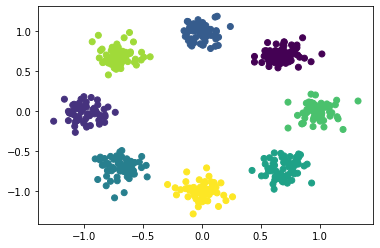

In [236]:
def kmeans(X, k, nrep=5, itermax=500):
    """kmeans: cluster data into k partitions

    Args:
        X (n x d np.ndarray): input data, rows = points, cols = dimensions
        k (int): Number of clusters to partition
        nrep (int): Number of repetitions to average for final clustering 
        itermax (int): Number of iterations to perform before terminating
    Returns:
        labels (n x 1 np.ndarray): Cluster labels assigned by kmeans
    """
    
    final_labels=[]
    final_centroids=[]
    for l in range(0, nrep): 
        init = kmeans_plusplus(X, k)  # find your initial centroids
        # perform kmeans
        
        labels=[]
        tolerance = 1
        centroids=init
        iterations = 0
        
        while ((iterations < itermax)&(tolerance > 10**-7)):

            old_centroids= np.copy(centroids)
        
            for i in range (0,len(X)):
                distances = [calculate_distance(X[i,:], centroids[j,:]) for j in range(0,  len(centroids))]    
                labels.append(distances.index(min(distances)))
           
        
            for z in range(0,k):
                indices =[idx for idx in range(0, len(labels)) if labels[idx] == z]
                for p in range(0, len(X[0,:])):
                    centroids[z,p]= np.mean(X[indices,p])


            iterations=iterations+1
            
            return_labels= np.copy(labels) 
            
            labels=[]
        
            tolerance= np.sum(np.abs(old_centroids-centroids))
        if iterations==itermax:
            return("K-means does not converge")
        if len(final_labels)==0:
            final_labels=return_labels.copy()
            final_centroids = centroids.copy()
        if closer_to_center(return_labels,centroids, final_labels, final_centroids,X)==True:
            final_labels=return_labels.copy()
            final_centroids=centroids.copy()
        
        
            
    return(final_labels)
            



A5, gt5, coordinates5 = sbm(500, 8, 0.65, .65, 0.01)
cents = kmeans(coordinates5 ,8)


plt.scatter(coordinates5[:,0], coordinates5[:,1], c = cents)



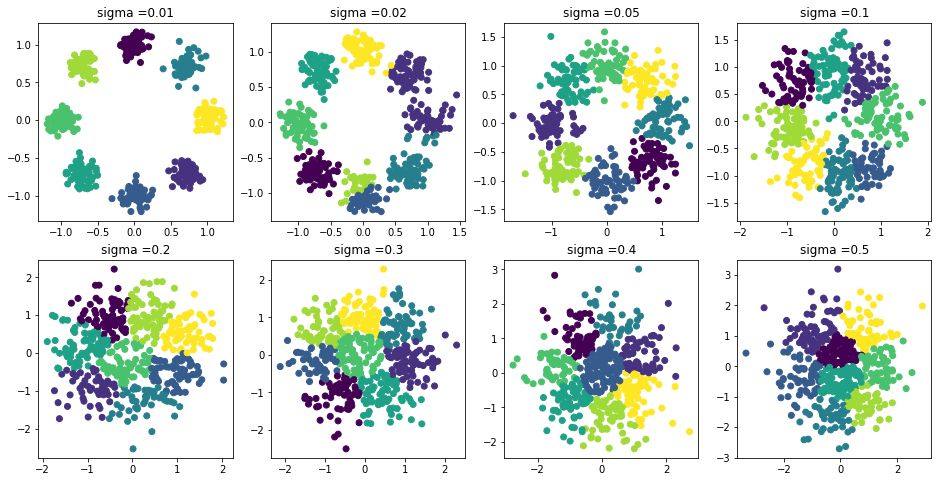

In [199]:
array= np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3,0.4,0.5])
figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

for d in range(0,len(array)): 
    A11, gt11, coordinates11 = sbm(500, 8, .65 , .65, array[d])
    labels=kmeans(coordinates11,8)
    plt.subplot(2,4, d+1)
    
    plt.title("sigma =" + str(array[d]))
    plt.scatter(coordinates11[:,0], coordinates11[:,1], c=labels)

In [237]:
def concentric_spheres(num_points, sigma):
    X = np.empty((num_points, 3))
    for i in range(0, num_points):
        point=np.array([np.random.normal(0, math.sqrt(sigma)), np.random.normal(0, math.sqrt(sigma)), np.random.normal(0, math.sqrt(sigma))])
        X[i,:]= point/(np.sqrt(sum(point**2)))
    for j in range(0, int(num_points/2)):
        X[j,:]= 10* X[j,:]
                                                                                                            
    return(X)

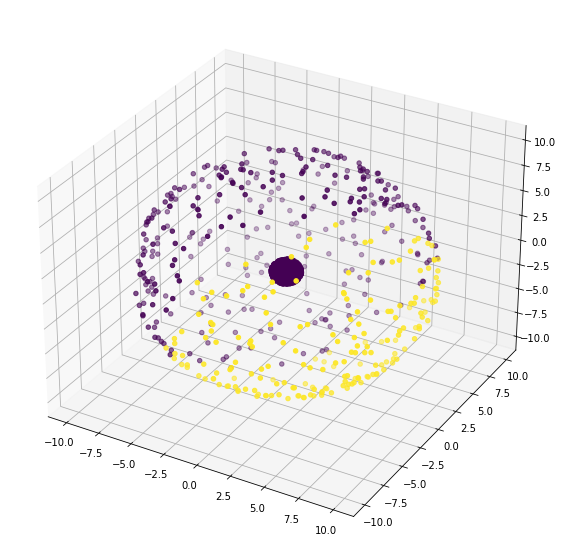

In [239]:
coords1=concentric_spheres(1000, 0.1 )
labels= kmeans(coords1, 2)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(coords1[:,0], coords1[:,1], coords1[:,2], c=labels)

In [ ]:
def SC(L, k, psi=None, nrep=5, itermax=300, sklearn=False):
    """SC: Perform spectral clustering 
            via the Ng method
    Args:
        L (np.ndarray): Normalized graph Laplacian
        k (integer): number of clusters to compute
        nrep (int): Number of repetitions to average for final clustering
        itermax (int): Number of iterations to perform before terminating
        sklearn (boolean): Flag to use sklearn kmeans to test your algorithm
    Returns:
        labels (N x 1 np.array): Learned cluster labels
    """
    if psi is None:
        u,v=eigh(L)
        indices=np.argsort(u)
        v=v[indices,:]
        psi_k=v[:,:k]
        # compute the first k elements of the Fourier basis
        # use scipy.linalg.eigh
        pass
    else:  # just grab the first k eigenvectors
        psi_k = psi[:, :k]
        
    psi_norm=np.empty(psi_k.shape)
    
    for i in range(0, len(psi_k)):
        rowsum= np.sqrt(sum(psi_k[i,:]**2))
        psi_norm[i,:]= psi_k[i,:]/rowsum

    if sklearn:
        labels = KMeans(n_clusters=k, n_init=nrep,
                        max_iter=itermax).fit_predict(psi_norm)
    else:
        pass
        labels=kmeans(psi_norm, k,nrep, itermax)
        
    return labels


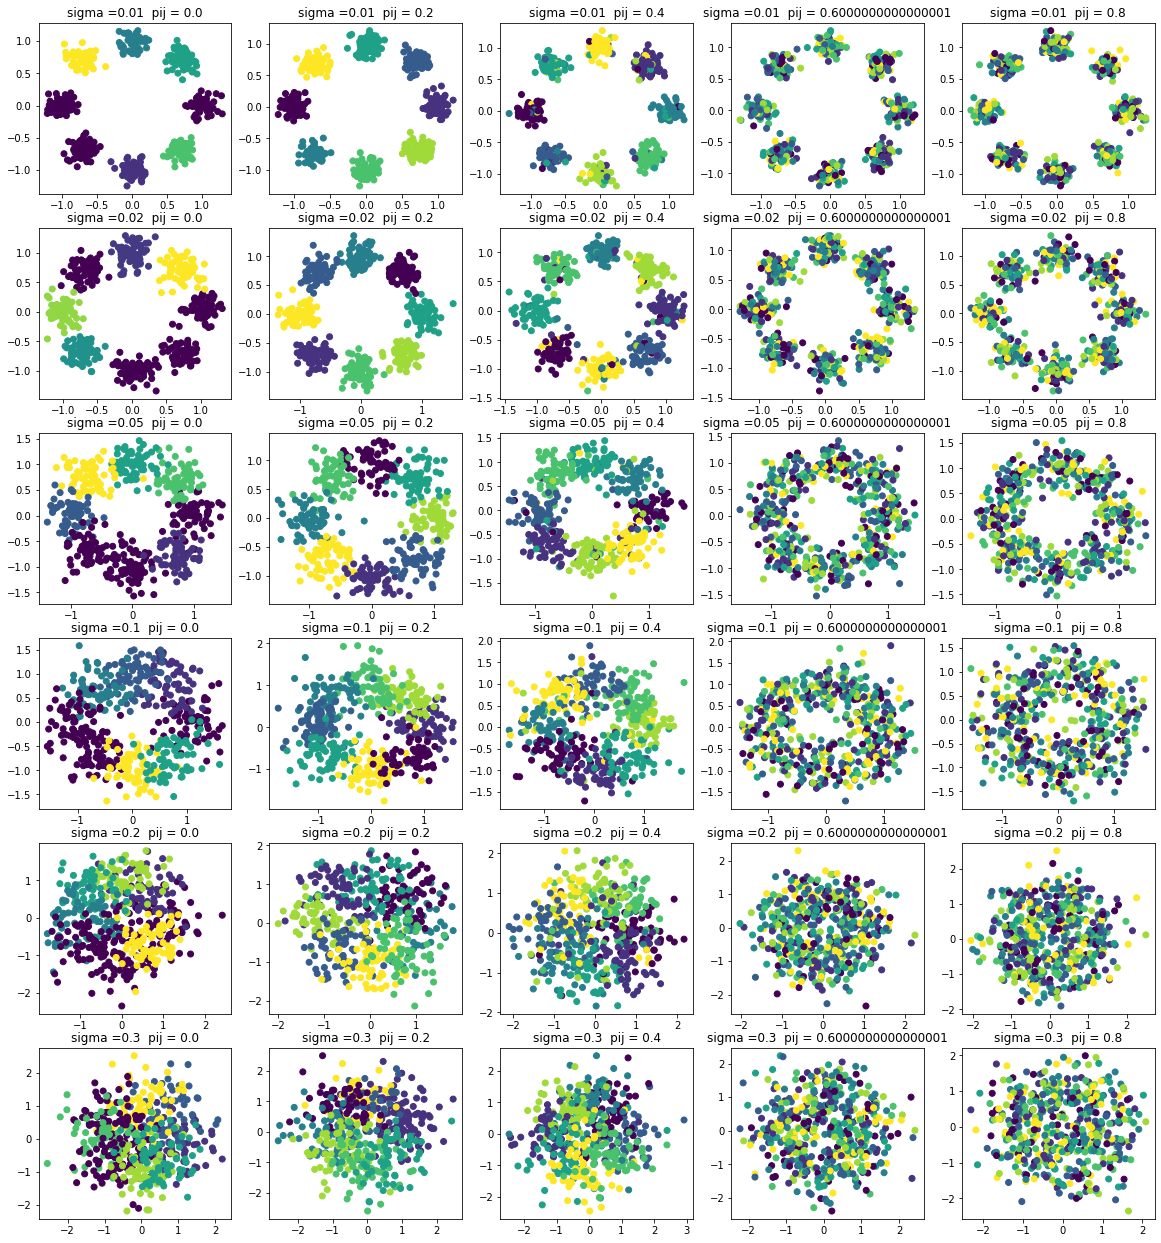

In [208]:
arraysigma= np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3])
arraypij=np.arange(0, 1, .2)
figure, axes = plt.subplots(nrows=6, ncols=5, figsize=(20,22))
l=0
for d in range(0,len(arraysigma)): 
    for p in range(0,len(arraypij)): 
    
        A12, gt12, coordinates12 = sbm(500, 8, arraypij[p] , .65, arraysigma[d])
        labels= SC(L(A12), 8)
        if(l<30):
            l=l+1
    
        
        plt.subplot(6,5, l)
    
        plt.title("sigma =" + str(arraysigma[d])+ "  pij = " + str(arraypij[p]))
        plt.scatter(coordinates12[:,0], coordinates12[:,1], c=labels)



fixed bandwidth specified


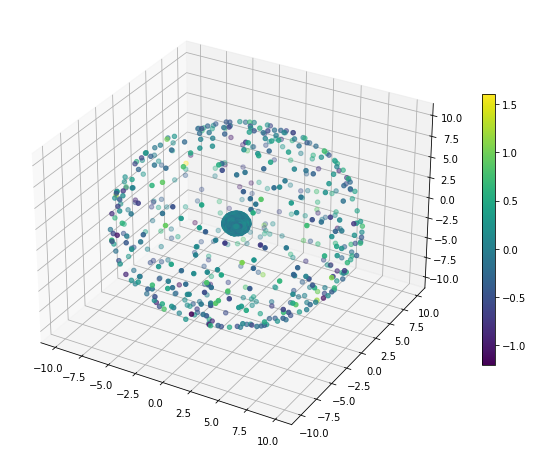

In [386]:

threshold4=0.0001
dist=gaussian_kernel(coords,'gaussian')
laplace=L(dist)
labels=np.concatenate((np.zeros(500)+np.random.normal(0,0.5,500), np.zeros(500)+np.random.normal(0,0.1,500)))
sphere_evals, sphere_evecs= compute_fourier_basis(laplace)
lowpassfilter = filterbank_matrix(sphere_evecs, sphere_evals, lambda x: int(x<threshold4))
filtered_sphere =  labels
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
scatter= ax.scatter(coords[:,0], coords[:,1], coords[:,2], c=filtered_sphere)
fig.colorbar(scatter, ax=ax, shrink=0.5)

fixed bandwidth specified


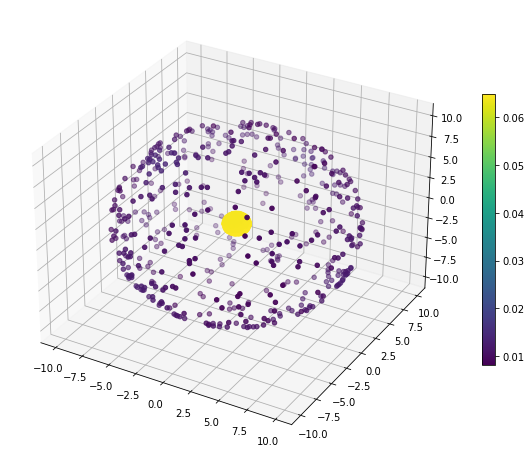

In [380]:

threshold4=0.00001
dist=gaussian_kernel(coords,'gaussian')
laplace=L(dist)
labels=np.concatenate((np.zeros(500)+np.random.normal(0,5,500), np.zeros(500)+np.random.normal(0,0.1,500)))
sphere_evals, sphere_evecs= compute_fourier_basis(laplace)
lowpassfilter = filterbank_matrix(sphere_evecs, sphere_evals, lambda x: int(x<threshold4))
filtered_sphere = lowpassfilter @ labels
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
scatter= ax.scatter(coords[:,0], coords[:,1], coords[:,2], c=filtered_sphere)
fig.colorbar(scatter, ax=ax, shrink=0.5)

fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified


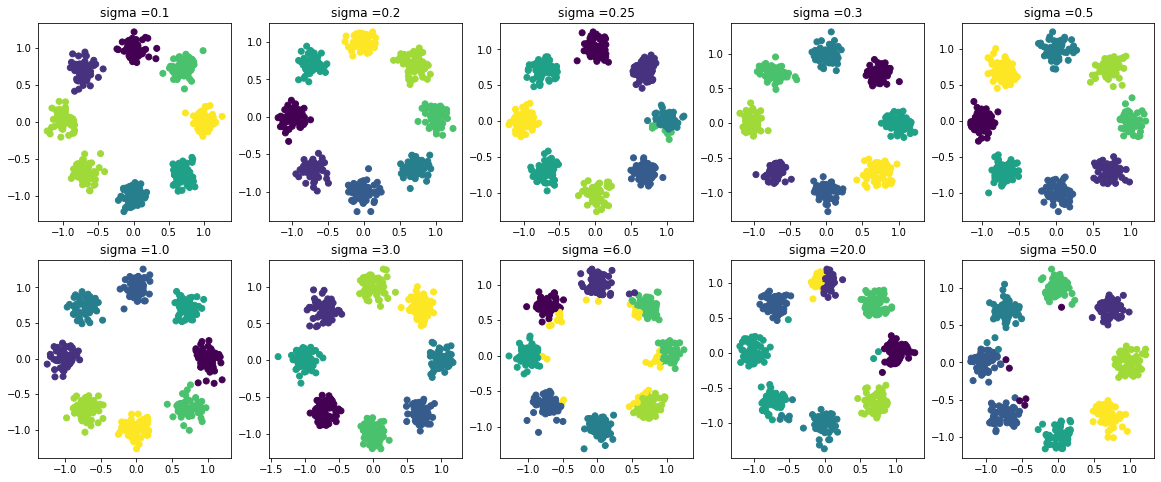

In [216]:
sigmaarray=[0.1, 0.2, 0.25,0.3, 0.5, 1.0, 3.0, 6.0, 20.0, 50.0]
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8))

for j in range(0, len(sigmaarray)):
    
    A13, gt13, coordinates13 = sbm(500, 8, 0, 0, 0.01)
    
    adj_matrix=gaussian_kernel(coordinates13, kernel_type= "gaussian", sigma= sigmaarray[j])

    labels13= SC(L(adj_matrix), 8)
    
    plt.subplot(2,5, j+1)
    
    plt.title("sigma ="+  str(sigmaarray[j]) )
    plt.scatter(coordinates13[:,0], coordinates13[:,1], c = labels13)
    

fixed bandwidth specified


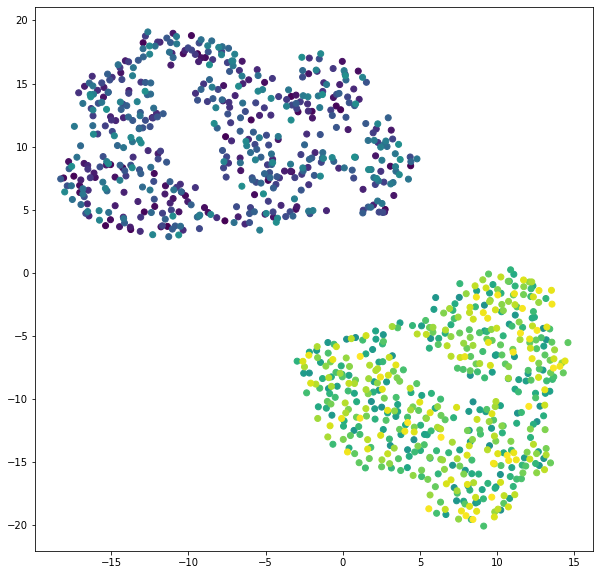

In [415]:
#phate_op = phate.PHATE()
#data_phate = phate_op.fit_transform(coords)
coords=concentric_spheres(1000, 0.1 )
dist=gaussian_kernel(coords,'gaussian')
laplace=L(dist)
G= nx.from_numpy_matrix(laplace)
partition = community_louvain.best_partition(G, resolution=1.1)
pos = list(partition.values())
sphere_evals, sphere_evecs= compute_fourier_basis(laplace)
data_tsne = TSNE(n_components=2, learning_rate='auto', init='random',  perplexity=100
                ).fit_transform(coords)

fig = plt.figure(figsize=(10, 10))
plt.scatter(data_tsne[:,0], data_tsne[:,1], c = pos)
fig.colorbar(scatter, ax=ax, shrink=0.5)


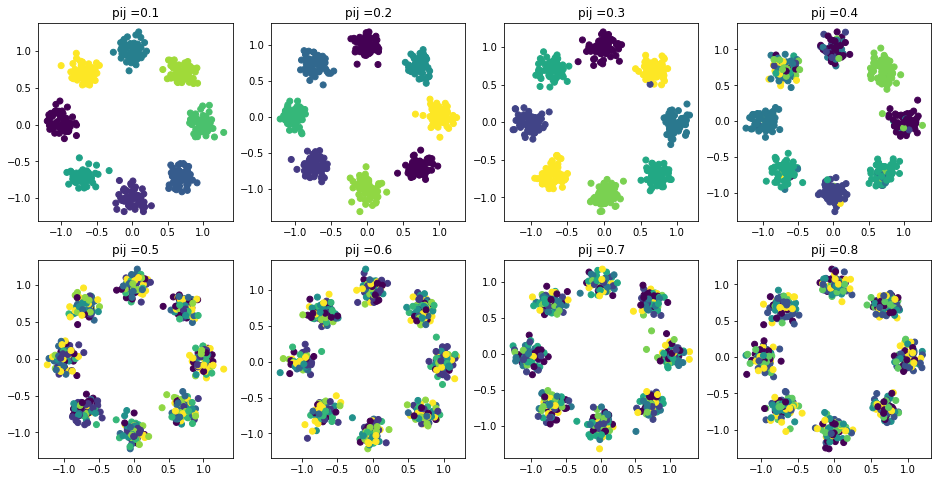

In [391]:

array= np.array([0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

for d in range(0,len(array)): 
    A11, gt11, coordinates11 = sbm(500, 8, array[d] , .65, 0.01)
    G= nx.from_numpy_matrix(A11)
    partition = community_louvain.best_partition(G)
    pos = list(partition.values())
    plt.subplot(2,4, d+1)
    
    plt.title("pij =" + str(array[d]))
    
    plt.scatter(coordinates11[:,0], coordinates11[:,1], c=pos)

fixed bandwidth specified


/opt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified


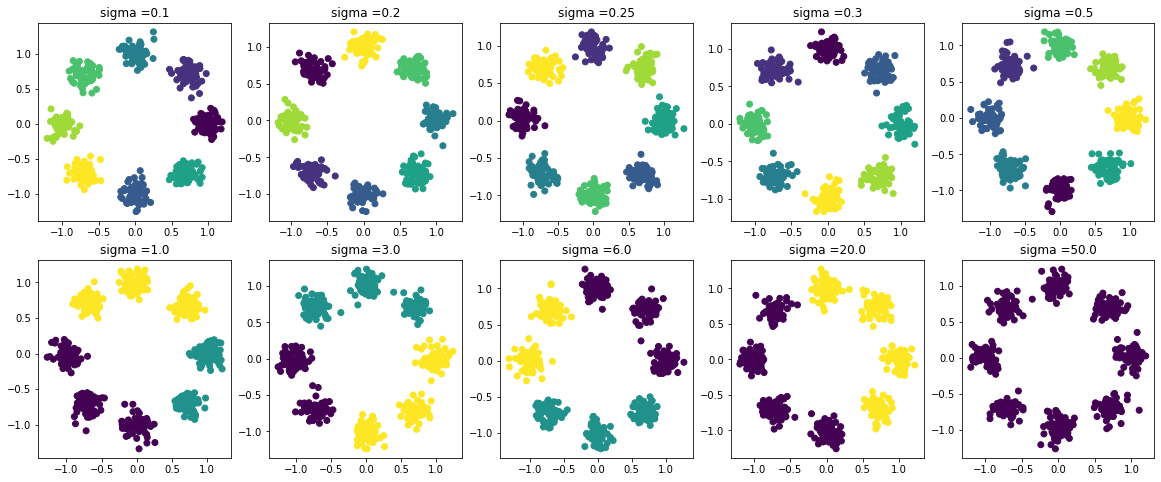

In [393]:
sigmaarray=[0.15, 0.2, 0.25,0.3, 0.5, 1.0, 3.0, 6.0, 20.0, 50.0]
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8))

for j in range(0, len(sigmaarray)):
    
    A13, gt13, coordinates13 = sbm(500, 8, 0, 0, 0.01)
    
    adj_matrix=gaussian_kernel(coordinates13, kernel_type= "gaussian", sigma= sigmaarray[j])
    G= nx.from_numpy_matrix(adj_matrix)
    partition = community_louvain.best_partition(G)
    pos = list(partition.values())
    labels13= SC(L(adj_matrix), 8)
    
    plt.subplot(2,5, j+1)
    
    plt.title("sigma ="+  str(sigmaarray[j]) )
    plt.scatter(coordinates13[:,0], coordinates13[:,1], c = pos)

In [218]:
pca_data = scprep.reduce.pca(retinal_data, n_components=100)

In [219]:
reduced_data = scprep.select.subsample(pca_data, n=3000, seed=8888)

In [220]:
G = gaussian_kernel(reduced_data, kernel_type="adaptive",  k=10)

adaptive bandwidth specified


In [221]:
reduced_data_numpy = reduced_data.to_numpy()
reduced_data.shape

(3000, 100)

In [222]:
K_clusters=kmeans(reduced_data_numpy, k = 15)


In [223]:
A= nx.from_numpy_matrix(G)
partition = community_louvain.best_partition(A)
louvain_labels= list(partition.values())

In [224]:

Spectral_clustering = SC(L(G), k = 15)

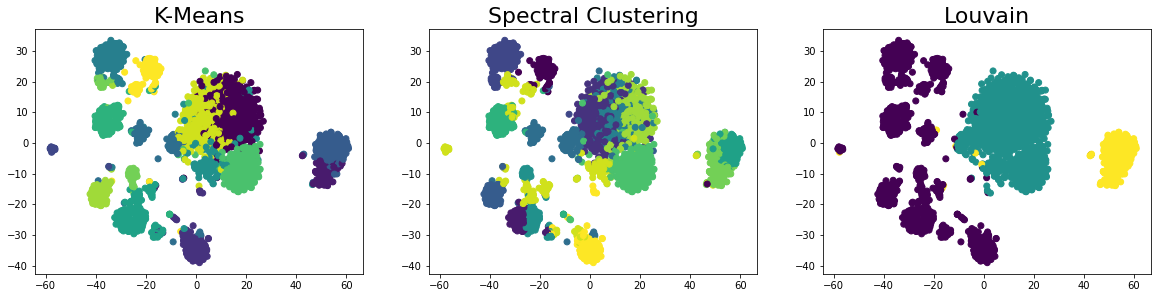

In [225]:
figure , axes = plt.subplots(nrows = 1, ncols = 3, figsize= (20, 4.5))
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(reduced_data_numpy)


plt.subplot(1,3,1)
plt.title('K-Means', fontsize=22)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=K_clusters)

plt.subplot(1,3,2)
plt.title('Spectral Clustering', fontsize=22)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=Spectral_clustering )

plt.subplot(1,3,3)
plt.title('Louvain', fontsize=22)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c= louvain_labels )

Calculating PHATE...
  Running PHATE on 3000 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.90 seconds.
    Calculating affinities...
    Calculated affinities in 0.24 seconds.
  Calculated graph and diffusion operator in 1.15 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.22 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.96 seconds.
  Calculated landmark operator in 4.06 seconds.
  Calculating optimal t...
    Automatically selected t = 33
  Calculated optimal t in 1.68 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.45 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.85 seconds.
Calculated PHATE in 12.19 seconds.


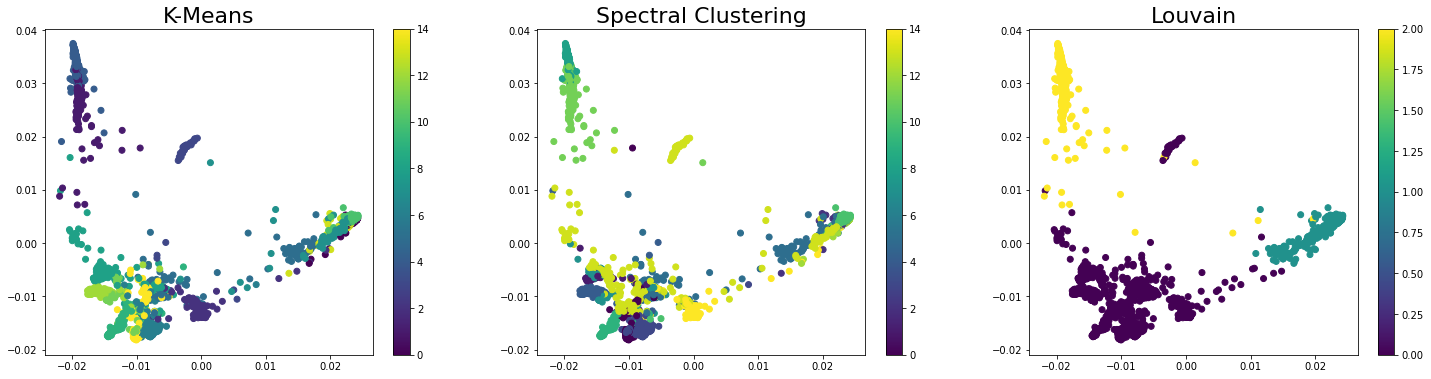

In [226]:
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(reduced_data_numpy)

figure , axes = plt.subplots(nrows = 1, ncols = 3, figsize= (25, 6))



plt.subplot(1,3,1)
plt.title('K-Means', fontsize=22)
dasha= plt.scatter(data_phate[:,0], data_phate[:,1], c=K_clusters, )
plt.colorbar(dasha, ax=axes[0])

plt.subplot(1,3,2)
plt.title('Spectral Clustering', fontsize=22)
fred= plt.scatter(data_phate[:,0], data_phate[:,1], c=Spectral_clustering )
plt.colorbar(fred, ax=axes[1])


plt.subplot(1,3,3)
plt.title('Louvain', fontsize=22)
louis= plt.scatter(data_phate[:,0], data_phate[:,1], c= louvain_labels )
plt.colorbar(louis, ax=axes[2])

In [227]:
df_metadata = retinal_metadata.loc[reduced_data.index]
df_metadata["CLUSTER"] = df_metadata["CLUSTER"].astype(int)
df_metadata["SUB-CLUSTER"] = df_metadata["SUB-CLUSTER"].astype(int)
df_metadata["CELLTYPE"] = pd.factorize(df_metadata["CELLTYPE"].values)[0] + 1
new_metadata = df_metadata.to_numpy()

Calculating PHATE...
  Running PHATE on 3000 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.27 seconds.
  Calculated graph and diffusion operator in 1.31 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.26 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.61 seconds.
  Calculated landmark operator in 4.98 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 1.72 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.43 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.29 seconds.
Calculated PHATE in 12.74 seconds.


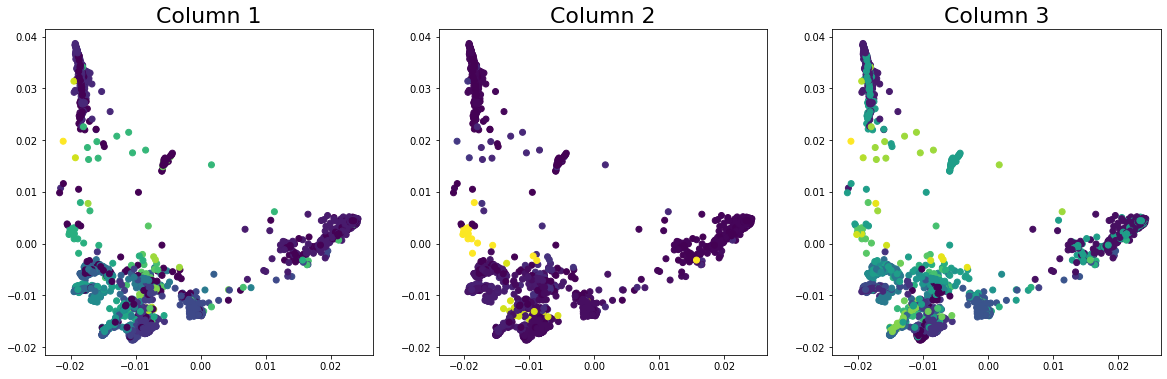

In [232]:
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(reduced_data_numpy)

figure , axes = plt.subplots(nrows = 1, ncols = 3, figsize= (20, 6))



plt.subplot(1,3,1)
plt.title('Column 1', fontsize=22)
plt.scatter(data_phate[:,0], data_phate[:,1], c=new_metadata[:,0])

plt.subplot(1,3,2)
plt.title('Column 2', fontsize=22)
plt.scatter(data_phate[:,0], data_phate[:,1], c=new_metadata[:,1] )

plt.subplot(1,3,3)
plt.title('Column 3', fontsize=22)
plt.scatter(data_phate[:,0], data_phate[:,1], c= new_metadata[:,2])

adaptive bandwidth specified
Calculating PHATE...
  Running PHATE on 3000 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.06 seconds.
    Calculating affinities...
    Calculated affinities in 0.27 seconds.
  Calculated graph and diffusion operator in 1.36 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.21 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.14 seconds.
  Calculated landmark operator in 4.41 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 1.83 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.51 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.69 seconds.
Calculated PHATE in 12.82 seconds.


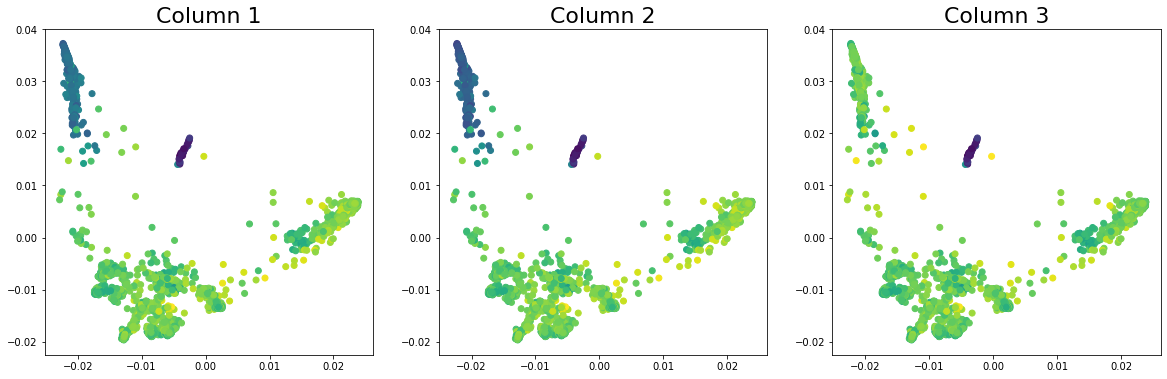

In [233]:
laplace3 = L(gaussian_kernel(reduced_data_numpy, kernel_type='adaptive', k=10))
evals3, evecs3 = compute_fourier_basis(laplace3)
filtered= filterbank_matrix(evecs3, evals3, lambda x: int(x<0.5))

phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(reduced_data_numpy)

figure , axes = plt.subplots(nrows = 1, ncols = 3, figsize= (20, 6))



plt.subplot(1,3,1)
plt.title('Column 1', fontsize=22)
plt.scatter(data_phate[:,0], data_phate[:,1], c=filtered @ new_metadata[:,0])

plt.subplot(1,3,2)
plt.title('Column 2', fontsize=22)
plt.scatter(data_phate[:,0], data_phate[:,1], c= filtered @ new_metadata[:,1] )

plt.subplot(1,3,3)
plt.title('Column 3', fontsize=22)
plt.scatter(data_phate[:,0], data_phate[:,1], c= filtered @  new_metadata[:,2])

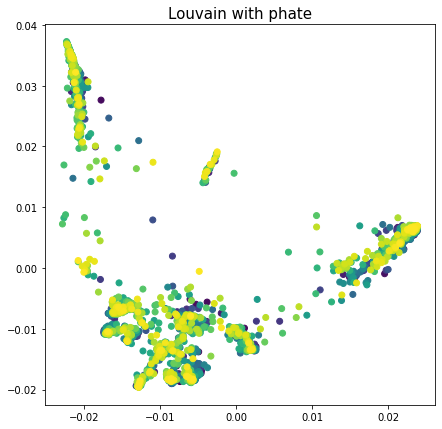

In [234]:
W_binarized = (G > 0.95).astype(int)
A20= nx.from_numpy_matrix(W_binarized)
partition4 = community_louvain.best_partition(A20)
louvain_labels2= list(partition4.values())
plt.figure(figsize=(7,7))
plt.title('Louvain with phate', fontsize=15)
plt.scatter(data_phate[:,0], data_phate[:,1], c=louvain_labels2)